In [1]:
###Import standard packages###
import numpy as np
from scipy import io

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from Area2_analysis.multi_area_funcs import smooth_spk, fit_and_predict, sub_and_predict, mp_fit_lag_r2, mp_sub_lag_r2, multi_fit_r2, multi_fit_coef
import multiprocessing as mp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Area2_analysis.lr_funcs import nans, angle_between
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
import math


## S1

### Load data

In [4]:
foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
filename = foldername + "s1_data_raw.mat"
s1_data_raw = io.loadmat(filename)

In [35]:
foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
filename = foldername + "s1_data_raw.mat"
s1_data_raw = io.loadmat(filename)

spike_times=s1_data_raw['spike_times']
acc = s1_data_raw['acc']
vel = s1_data_raw['vels']
pos = s1_data_raw['pos']
times = s1_data_raw['vel_times']

#original data has 0.01 s = 10 ms bins 
dt = 0.01
t_start = times[0]
t_end = times[-1]

spike_times = np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])

neural_data=bin_spikes(spike_times,dt,t_start,t_end)
gauss_width = 40 #in ms
bin_width = dt*1000
smth_40 = smooth_spk(neural_data, gauss_width, bin_width)

accs_binned=bin_output(acc,times,dt,t_start,t_end)
vels_binned=bin_output(vel,times,dt,t_start,t_end)
pos_binned=bin_output(pos,times,dt,t_start,t_end)
accs_40 = smooth_spk(accs_binned, gauss_width, bin_width)
vels_40 = smooth_spk(vels_binned, gauss_width, bin_width)
pos_40 = smooth_spk(pos_binned, gauss_width, bin_width)

with open(foldername+'proc_data_s1.pickle','wb') as f:
    pickle.dump([smth_40,accs_40,vels_40, pos_40],f)

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "s1_data_raw.mat"
# s1_data_raw = io.loadmat(filename)

# spike_times=s1_data_raw['spike_times']
# acc = s1_data_raw['acc']
# vel = s1_data_raw['vels']
# pos = s1_data_raw['pos']
# times = s1_data_raw['vel_times']

# #original data has 0.01 s = 10 ms bins 
# dt = 0.02 #10ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_20=bin_spikes(spike_times,dt,t_start,t_end)
# accs_20_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_20_binned=bin_output(vel,times,dt,t_start,t_end)
# pos_20_binned=bin_output(pos,times,dt,t_start,t_end)

# with open(foldername+'proc_20_data_s1.pickle','wb') as f:
#     pickle.dump([neural_data_20,accs_20_binned,vels_20_binned,pos_20_binned],f)

### Single-lag

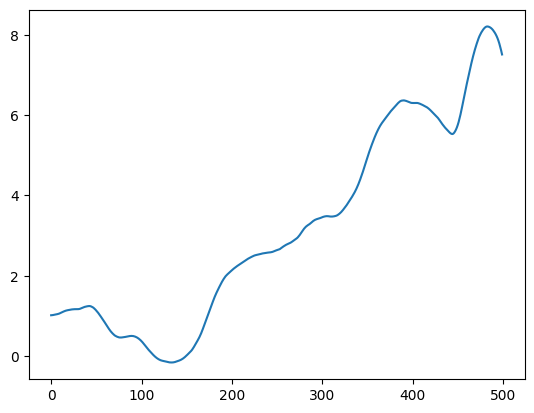

In [87]:
# plt.scatter(pos[500,0],pos[500,1])
# plt.plot(pos[500:1000,0],pos[500:1000,1])
plt.plot(pos_binned[500:1000,0])

In [2]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_s1.pickle','rb') as f:
    neural_data, accs, vels, pos = pickle.load(f,encoding='latin1')
print(neural_data.shape)
print(accs.shape)
print(vels.shape)
print(pos.shape)

n_neurons = neural_data.shape[1]

n_dims = 20
if not np.isnan(neural_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(neural_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_pc = pca.fit_transform(X)
    print(neural_pc.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
s1_pca = neural_pc

(306698, 52)
(306698, 2)
(306698, 2)
(306698, 2)
(306698, 20)
PCA total var explained: 0.5621270379402465


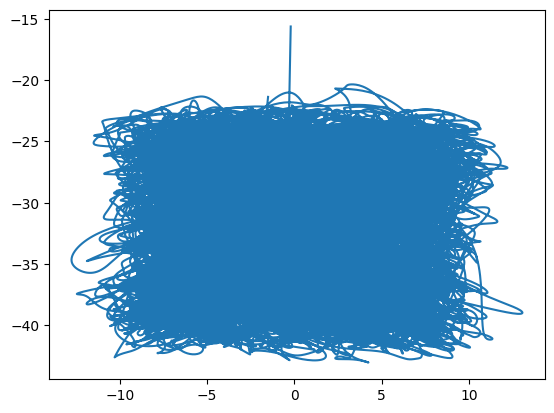

In [160]:
plt.plot(pos[:,0],pos[:,1])

from matplotlib import pyplot as plt
 
x = []
y = []
 
for i in range(100):
    x.append(pos[i,0])
    y.append(i)
 
    # Mention x and y limits to define their range
    plt.xlim(0, 100)
    plt.ylim(0, 100)
     
    # Plotting graph
    plt.plot(x, y, color = 'green')
    plt.pause(0.01)
 
plt.show()

(1, 306698, 2)


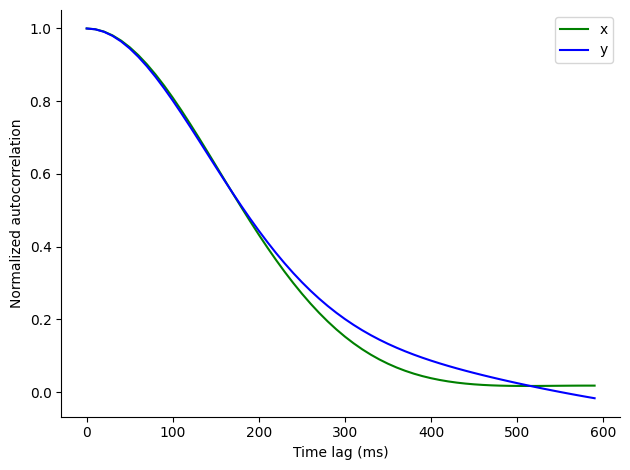

In [46]:
from Area2_analysis.lr_funcs import comp_cc
acc_array = vels.reshape(1, -1, 2)
print(acc_array.shape)
maxTimeLag = 600
binSize = 10
numBin = acc_array.shape[1]
x1 = acc_array[:,:,0]
x2 = acc_array[:,:,0]
ac_x = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

x1 = acc_array[:,:,1]
x2 = acc_array[:,:,1]
ac_y = comp_cc(x1,x2,maxTimeLag,binSize,numBin)

time_axis = np.arange(0, maxTimeLag, binSize)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(time_axis,ac_x/ac_x[0],color = 'green', label = 'x')
ax.plot(time_axis,ac_y/ac_y[0],color = 'blue', label = 'y')
plt.legend()
plt.xlabel("Time lag (ms)")
plt.ylabel("Normalized autocorrelation")
plt.tight_layout()
# plt.savefig(figDir + monkey + '_autocorrelation_acc.pdf',dpi = 'figure')

In [158]:
from sklearn.linear_model import LinearRegression
lag_axis = np.arange(-200, 200, 10)
n_runs = 25
ang_arr = nans([n_runs])
r2_arr = nans([n_runs, len(lag_axis)])
for b in range(n_runs):
    mu, sigma = 0, 1
    n_nrn = 20
    nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,2)) # Random We and Wa
    nrn_weight_0 = np.random.normal(mu, sigma, size = (n_nrn,2))

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.tile(nrn_weight,(1,2)) # Random We = Wa

    # nrn_weight = np.random.normal(mu, sigma, size = (n_nrn,1))
    # nrn_weight = np.concatenate([nrn_weight, -nrn_weight], axis = 1) # Random We = -Wa

    nrn_axis = np.arange(0+20, len(neural_data)-20)
    n_bins = len(nrn_axis)
    nrn_activity = nans([n_bins, n_nrn])
    for n in range(n_nrn):
        for i in range(n_bins):
            nrn_activity[i, n] = nrn_weight[n,0]*accs[i+10, 0] + nrn_weight[n, 1]*accs[i+30, 0] + nrn_weight_0[n,0]*vels[i+10, 0] + nrn_weight_0[n, 1]*vels[i+30, 0]
            # nrn_activity[i, n] = nrn_weight[n,0]*vels[i+20, 0] 

    coefs_arr = nans([len(lag_axis), n_nrn])
    r2 = nans([len(lag_axis)])
    for i in range(len(lag_axis)):
        start, end = 40-i, len(neural_data)-i
        X = nrn_activity
        y = accs[start:end,0]
        lr =  LinearRegression().fit(X, y)
        coefs_arr[i] = lr.coef_
        r2[i] = lr.score(X, y)
    ang_arr[b] = math.degrees(angle_between(coefs_arr[np.argwhere(lag_axis==-100)[0,0],:],coefs_arr[np.argwhere(lag_axis==100)[0,0],:])) 
    r2_arr[b,:] = r2

Text(0, 0.5, 'R2')

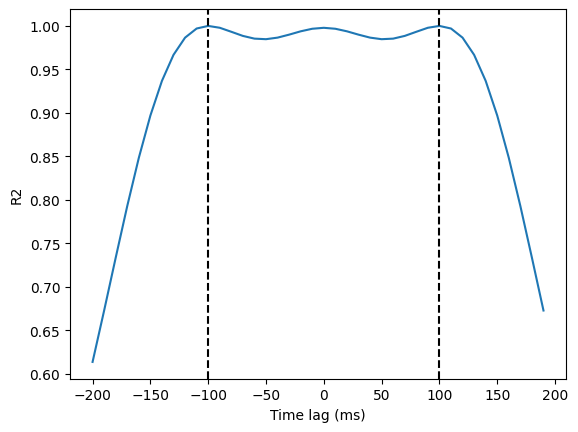

In [159]:
plt.plot(lag_axis, np.mean(r2_arr,axis=0))
plt.axvline(-100, color = 'k', linestyle='--')
plt.axvline(100, color = 'k', linestyle='--')
plt.xlabel("Time lag (ms)")
plt.ylabel('R2')

Text(0, 0.5, 'Frequency')

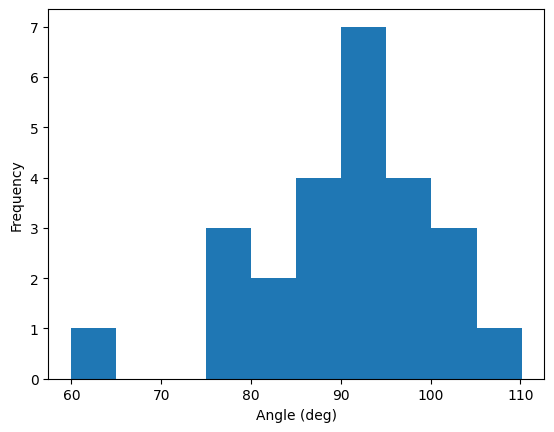

In [157]:
plt.hist(ang_arr)
plt.xlabel("Angle (deg)")
plt.ylabel('Frequency')

In [3]:
from Area2_analysis.lr_funcs import nans
lag_axis = np.arange(-300, 300, 20)
dim = n_dims
x = s1_pca
y = vels
r2_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = fit_and_predict(x,y,lag,bin_size=10)
    r2_array[i] = r2
    coef_array[i,:,:] = coef

0.12969657258056078
R2: 0.12784867052253224
0.15162273549157262
R2: 0.1494695211269237
0.17725513393041384
R2: 0.17482948303642454
0.20664131390609453
R2: 0.20400292007126297
0.23971115907663249
R2: 0.23694446993518614
0.27627909206305856
R2: 0.273477863270832
0.3159847149692746
R2: 0.31325750355509496
0.3582556040571521
R2: 0.35569949531156
0.4021610377797445
R2: 0.39986001132452587
0.4462827548930644
R2: 0.44429873755480886
0.48860282462810023
R2: 0.48696666484625417
0.5264766255576502
R2: 0.5251953795116937
0.5568212073691563
R2: 0.5558747001730138
0.5765188108514705
R2: 0.5758675518586469
0.5830575948284895
R2: 0.5826470175045383
0.5752362190918305
R2: 0.5750026091849725
0.5536928130769654
R2: 0.5535680432520549
0.5209377171314482
R2: 0.5208552697136806
0.4808233632035793
R2: 0.4807213739862549
0.4375589856931407
R2: 0.4373841577657136
0.3947288882832721
R2: 0.3944374904699336
0.35468993847884067
R2: 0.3542536902029675
0.31851834327808215
R2: 0.3179259139707181
0.28635863818115775


KeyboardInterrupt: 

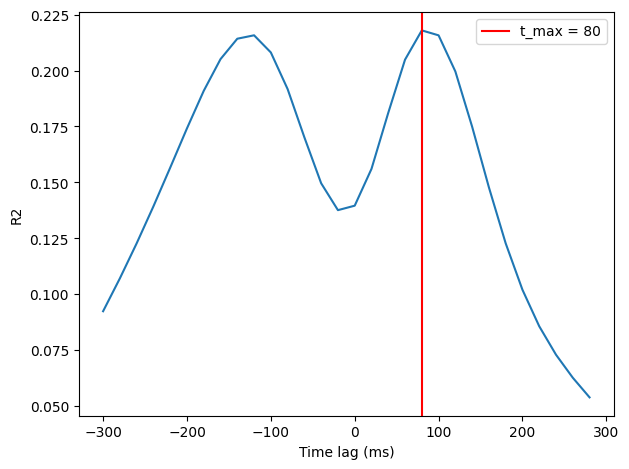

In [152]:
idx_max = np.argmax(r2_array)
time_max = lag_axis[idx_max]
plt.plot(lag_axis, r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig(figDir + y_field +'_0.png', dpi = 'figure')
plt.show()

R2: 0.21799542953251783


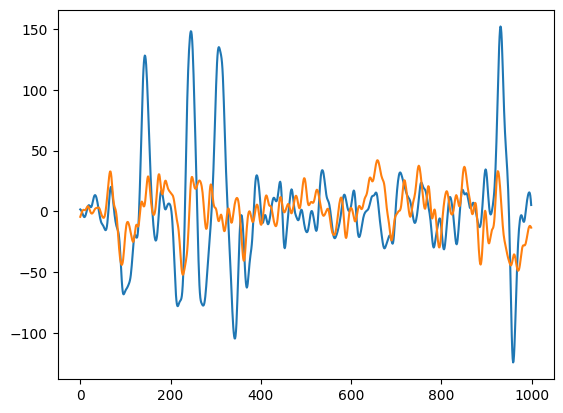

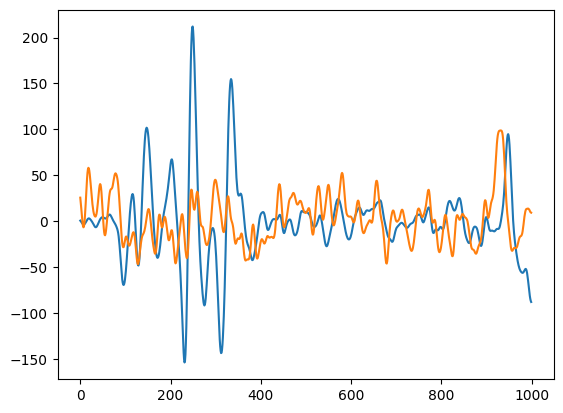

In [154]:
_, _, vel_df = fit_and_predict(x,y,time_max,bin_size=10)
plt.plot(vel_df['true_x'][:1000])
plt.plot(vel_df['pred_x'][:1000])
plt.show()
plt.plot(vel_df['true_y'][:1000])
plt.plot(vel_df['pred_y'][:1000])

In [99]:
best_decoder = coef_array[idx_max,:,:]
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_ = sub_and_predict(x,y,lag,10,best_decoder)
    sub_r2_array[i] = r2

R2: 0.14941366767914022
R2: 0.17375683309065149
R2: 0.20192455312487811
R2: 0.2336885610118179
R2: 0.2685947424296101
R2: 0.30598660607164674
R2: 0.3450493667615867
R2: 0.3848670738004244
R2: 0.42444945049871363
R2: 0.4627163792994192
R2: 0.4984175018031035
R2: 0.5300307613768866
R2: 0.555697139209463
R2: 0.573333143802021
R2: 0.5809679238420252
R2: 0.5772870567983344
R2: 0.5621842278456114
R2: 0.5370067148821223
R2: 0.5043374405922877
R2: 0.4673204187866373
R2: 0.428883471640673
R2: 0.39120870010270825
R2: 0.3556171497626689
R2: 0.3227691826888347
R2: 0.29294324614406464
R2: 0.26624503336200267
R2: 0.24269312844827584
R2: 0.2222361716058
R2: 0.20474773160210402
R2: 0.19002894753336486


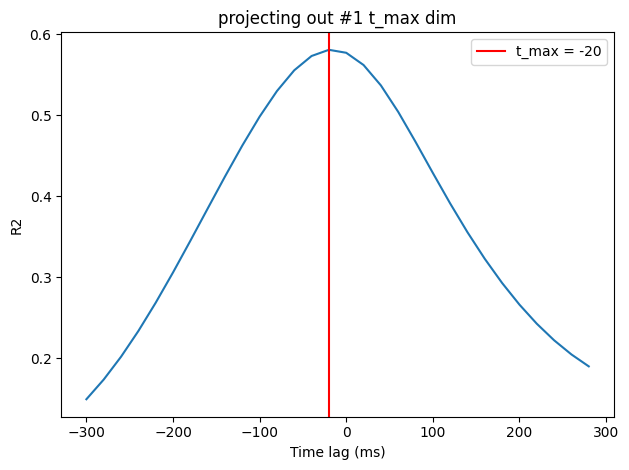

In [100]:
plt.plot(lag_axis,sub_r2_array)
plt.title('projecting out #1 t_max dim')
idx_max = np.argmax(sub_r2_array)
time_max = lag_axis[idx_max]
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig(figDir + y_field +'_1.png', dpi = 'figure')
plt.show()

89.41081188904903


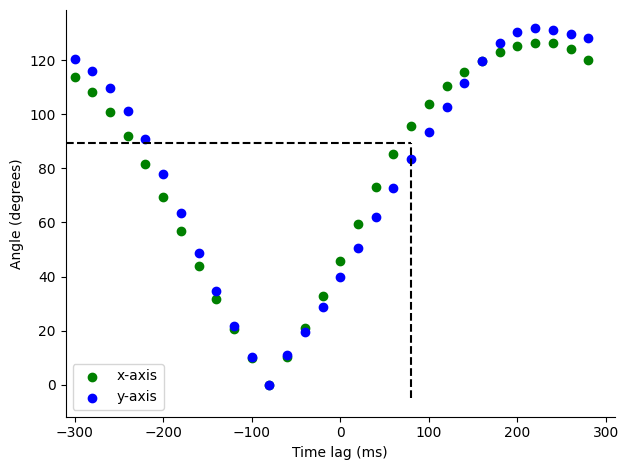

In [96]:
idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]

# idx_max_pos = np.argwhere(lag_axis==40)[0,0]
# idx_max_neg = np.argwhere(lag_axis==-60)[0,0]

ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_neg,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_neg,1,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x-axis',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y-axis',color = 'blue')
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')
mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
print(mean)
plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
plt.show()

### Multi-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_s1.pickle','rb') as f:
    s1_neural_data_50,s1_accs_50_binned,s1_vels_50_binned,s1_pos_50_binned=pickle.load(f,encoding='latin1')
print(s1_neural_data_50.shape)
print(s1_accs_50_binned.shape)
print(s1_vels_50_binned.shape)
print(s1_pos_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(s1_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(s1_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
s1_neural_data_50_pca = neural_data_50_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_acc'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/S1/"
    x = s1_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/S1/"
    x = s1_neural_data_50_pca
if y_field == 'hand_vel':
    y = s1_vels_50_binned
if y_field == 'hand_acc':
    y = s1_accs_50_binned

t_before_range = range(0,301,50)
t_after_range = range(0,301,50)
s1_multi_R2s = nans([len(t_before_range),len(t_after_range)])
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        s1_multi_R2s[j,k] = multi_fit_r2(X_chopped,y_chopped)
        print('R2:',s1_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(s1_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(s1_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.show()
plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
plt.close()

t_before = 300
t_after = 300
dim = n_dims
print('Predicting with',-t_before, 'to', t_after,'ms neural data')
bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
bins_current= 1 #Whether to use concurrent time bin of neural data
bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
print(X_flat.shape)
X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
coef_X = multi_fit_coef(X_chopped,y_chopped)

t_label = np.arange(-300,301,50)
n_weights = len(t_label)
coef_X_reshaped = coef_X[0,:].reshape(n_weights,dim)
angDist_array = nans([n_weights,n_weights])
for i in range(n_weights):
    for j in range(n_weights):
        angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(angDist_array)
ax.set_xlabel('Bin time (ms)')
ax.set_ylabel('Bin time (ms)')

ax.set_xticks(np.arange(len(t_label)))
ax.set_yticks(np.arange(len(t_label)))
ax.set_xticklabels(labels=t_label)
ax.set_yticklabels(labels=t_label)

ax.set_title("Angle between weight vectors at time points")
fig.tight_layout()

for i in range(len(t_label)):
    for j in range(len(t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w")
plt.tight_layout()
plt.savefig(figDir + y_field + '_multi_lag_angles.png', dpi = 'figure')
plt.close()

## M1

### Load data

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# m1_data_raw = io.loadmat(filename)

# spike_times=m1_data_raw['spike_times'][:70,:] #only first 70 are M1 neurons
# acc = m1_data_raw['acc']
# vel = m1_data_raw['vels']
# times = m1_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.01
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data=bin_spikes(spike_times,dt,t_start,t_end)
# gauss_width = 40 #in ms
# bin_width = dt*1000
# smth_40 = smooth_spk(neural_data, gauss_width, bin_width)
# smth_20 = smooth_spk(neural_data, 20, bin_width)

# accs_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_data_m1.pickle','wb') as f:
#     pickle.dump([smth_40, smth_20,accs_binned,vels_binned],f)

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# m1_data_raw = io.loadmat(filename)

# spike_times=m1_data_raw['spike_times'][:70,:]
# acc = m1_data_raw['acc']
# vel = m1_data_raw['vels']
# times = m1_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.05 #50ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_50=bin_spikes(spike_times,dt,t_start,t_end)
# accs_50_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_50_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_50_data_m1.pickle','wb') as f:
#     pickle.dump([neural_data_50,accs_50_binned,vels_50_binned],f)

### Single-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_m1.pickle','rb') as f:
    m1_smth_40,m1_smth_20,m1_accs_binned, m1_vels_binned=pickle.load(f,encoding='latin1')
print(m1_smth_40.shape)
print(m1_smth_20.shape)
print(m1_accs_binned.shape)
print(m1_vels_binned.shape)

n_neurons = m1_smth_20.shape[1]

n_dims = 20
if not np.isnan(m1_smth_40).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(m1_smth_40)
    pca = PCA(n_components=n_dims,random_state = 42)
    smth_40_pca = pca.fit_transform(X)
    print(smth_40_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
m1_40_pca = smth_40_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/M1/"
    x = m1_smth_40
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/M1/"
    x = m1_40_pca
if y_field == 'hand_vel':
    y = m1_vels_binned
if y_field == 'hand_acc':
    y = m1_accs_binned

lag_axis = np.arange(-300,300,20)
pool = mp.Pool(mp.cpu_count())
m1_r2_array = [pool.starmap(mp_fit_lag_r2, [(x,y,lag,10) for lag in lag_axis])][0]
pool.close()

idx_max = np.argmax(m1_r2_array)
time_max = lag_axis[idx_max]
plt.plot(lag_axis, m1_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score predicting ' + y_field )
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_0.png', dpi = 'figure')
plt.close()

_, weights, _ = fit_and_predict(x,y,time_max,bin_size=10)
#subtract projection on primary decoding dimensions (at time with max R2)
pool = mp.Pool(mp.cpu_count())
m1_sub_r2_array = [pool.starmap(mp_sub_lag_r2, [(x,y,lag,10,weights) for lag in lag_axis])][0]
pool.close()
plt.plot(lag_axis,m1_sub_r2_array)
plt.title('R2 score projecting out #1 t_max dim')
idx_max = np.argmax(m1_sub_r2_array)
time_max = lag_axis[idx_max]
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_1.png', dpi = 'figure')
plt.close()


### Multi-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_m1.pickle','rb') as f:
    m1_neural_data_50,m1_accs_50_binned,m1_vels_50_binned=pickle.load(f,encoding='latin1')
print(m1_neural_data_50.shape)
print(m1_accs_50_binned.shape)
print(m1_vels_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(m1_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(m1_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
m1_neural_data_50_pca = neural_data_50_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/M1/"
    x = m1_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/M1/"
    x = m1_neural_data_50_pca
if y_field == 'hand_vel':
    y = m1_vels_50_binned
if y_field == 'hand_acc':
    y = m1_accs_50_binned

t_before_range = range(0,301,50)
t_after_range = range(0,301,50)
m1_multi_R2s = nans([len(t_before_range),len(t_after_range)])
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        m1_multi_R2s[j,k] = multi_fit_r2(X_chopped,y_chopped)
        print('R2:',m1_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(m1_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(m1_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
plt.close()

## PMd

### Load data

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# pmd_data_raw = io.loadmat(filename)

# spike_times=pmd_data_raw['spike_times'][70:,:] #neurons after 70 are PMd neurons
# acc = pmd_data_raw['acc']
# vel = pmd_data_raw['vels']
# times = pmd_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.01
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data=bin_spikes(spike_times,dt,t_start,t_end)
# gauss_width = 40 #in ms
# bin_width = dt*1000
# smth_40 = smooth_spk(neural_data, gauss_width, bin_width)
# smth_20 = smooth_spk(neural_data, 20, bin_width)

# accs_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_data_pmd.pickle','wb') as f:
#     pickle.dump([smth_40, smth_20,accs_binned,vels_binned],f)

In [ ]:
# foldername = "/Users/sherryan/area2_population_analysis/multi_area/"
# filename = foldername + "m1_data_raw.mat"
# pmd_data_raw = io.loadmat(filename)

# spike_times=pmd_data_raw['spike_times'][70:,:]
# acc = pmd_data_raw['acc']
# vel = pmd_data_raw['vels']
# times = pmd_data_raw['vel_times']

# #original data has 0.001 s = 1 ms bins 
# dt = 0.05 #50ms bins
# t_start = times[0]
# t_end = times[-1]

# spike_times = np.squeeze(spike_times)
# for i in range(spike_times.shape[0]):
#     spike_times[i]=np.squeeze(spike_times[i])

# neural_data_50=bin_spikes(spike_times,dt,t_start,t_end)
# accs_50_binned=bin_output(acc,times,dt,t_start,t_end)
# vels_50_binned=bin_output(vel,times,dt,t_start,t_end)

# with open(foldername+'proc_50_data_pmd.pickle','wb') as f:
#     pickle.dump([neural_data_50,accs_50_binned,vels_50_binned],f)

### Single-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_data_pmd.pickle','rb') as f:
    pmd_smth_40,pmd_smth_20,pmd_accs_binned, pmd_vels_binned=pickle.load(f,encoding='latin1')
print(pmd_smth_40.shape)
print(pmd_smth_20.shape)
print(pmd_accs_binned.shape)
print(pmd_vels_binned.shape)

n_neurons = pmd_smth_20.shape[1]

n_dims = 20
if not np.isnan(pmd_smth_40).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(pmd_smth_40)
    pca = PCA(n_components=n_dims,random_state = 42)
    smth_40_pca = pca.fit_transform(X)
    print(smth_40_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
pmd_40_pca = smth_40_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_vel'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/PMd/"
    x = pmd_smth_40
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/PMd/"
    x = pmd_40_pca
if y_field == 'hand_vel':
    y = pmd_vels_binned
if y_field == 'hand_acc':
    y = pmd_accs_binned

lag_axis = np.arange(-300,300,20)
pool = mp.Pool(mp.cpu_count())
pmd_r2_array = [pool.starmap(mp_fit_lag_r2, [(x,y,lag,10) for lag in lag_axis])][0]
pool.close()

idx_max = np.argmax(pmd_r2_array)
time_max = lag_axis[idx_max]
plt.plot(lag_axis, pmd_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score predicting ' + y_field )
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_0.png', dpi = 'figure')
plt.close()

_, weights, _ = fit_and_predict(x,y,time_max,bin_size=10)
#subtract predictions with primary decoding dimensions (at time with max R2)
pool = mp.Pool(mp.cpu_count())
pmd_sub_r2_array = [pool.starmap(mp_sub_lag_r2, [(x,y,lag,10,weights) for lag in lag_axis])][0]
pool.close()
plt.plot(lag_axis,pmd_sub_r2_array)
plt.title('R2 score projecting out #1 t_max dim')
idx_max = np.argmax(pmd_sub_r2_array)
time_max = lag_axis[idx_max]
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.savefig(figDir + y_field +'_1.png', dpi = 'figure')
plt.close()


### Multi-lag

In [ ]:
folder="/Users/sherryan/area2_population_analysis/multi_area/"

with open(folder+'proc_50_data_pmd.pickle','rb') as f:
    pmd_neural_data_50,pmd_accs_50_binned,pmd_vels_50_binned=pickle.load(f,encoding='latin1')
print(pmd_neural_data_50.shape)
print(pmd_accs_50_binned.shape)
print(pmd_vels_50_binned.shape)

bin_width = 50

n_dims = 20
if not np.isnan(pmd_neural_data_50).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(pmd_neural_data_50)
    pca = PCA(n_components=n_dims,random_state = 42)
    neural_data_50_pca = pca.fit_transform(X)
    print(neural_data_50_pca.shape)
    print('PCA total var explained:',sum(pca.explained_variance_ratio_))
pmd_neural_data_50_pca = neural_data_50_pca

In [ ]:
x_field = 'PCA'
y_field = 'hand_acc'

if x_field == 'neurons':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/neurons/PMd/"
    x = pmd_neural_data_50
if x_field == 'PCA':
    figDir = "/Users/sherryan/area2_population_analysis/figures/multi/PCA/PMd/"
    x = pmd_neural_data_50_pca
if y_field == 'hand_vel':
    y = pmd_vels_50_binned
if y_field == 'hand_acc':
    y = pmd_accs_50_binned

t_before_range = range(0,301,50)
t_after_range = range(0,301,50)
pmd_multi_R2s = nans([len(t_before_range),len(t_after_range)])
j,k = 0,0
for t_before in t_after_range:
    for t_after in t_after_range:
        print('Predicting with',-t_before, 'to', t_after,'ms neural data')
        bins_before= int(t_before/bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(t_after/bin_width) #How many bins of neural data after the output are used for decoding
        X_cov = get_spikes_with_history(x,bins_before,bins_after,bins_current)
        X_flat = X_cov.reshape(X_cov.shape[0],(X_cov.shape[1]*X_cov.shape[2]))
        print(X_flat.shape)
        X_chopped = X_flat[~np.isnan(X_flat).any(axis = 1)]
        y_chopped = y[0+bins_before:y.shape[0]-bins_after,:]
        pmd_multi_R2s[j,k] = multi_fit_r2(X_chopped,y_chopped)
        print('R2:',pmd_multi_R2s[j,k])
        k+=1
    j+=1
    k=0

fig, ax = plt.subplots()
im = ax.imshow(pmd_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title('R2 predicting ' + y_field +' with different lagging/leading info')
fig.tight_layout()
for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(pmd_multi_R2s[i, j]*1000)/1000),
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.savefig(figDir + y_field + '_multi_lag.png', dpi = 'figure')
plt.close()